<a href="https://colab.research.google.com/github/Pranto210102/CNN-FashionMNIST-Project-Pranto/blob/main/210102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Pranto210102/CNN-FashionMNIST-Project-Pranto.git

Cloning into 'CNN-FashionMNIST-Project-Pranto'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 35 (delta 5), reused 19 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 1.53 MiB | 10.84 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [2]:
%cd CNN-FashionMNIST-Project-Pranto

/content/CNN-FashionMNIST-Project-Pranto


In [3]:
!ls

210102.ipynb  dataset  kaggle_data  README.md


In [4]:
!ls kaggle_data

fashion-mnist_test.csv	fashion-mnist_train.csv  README_blank.md  README.md


In [5]:
!ls dataset

bag1.jpg  sandal1.jpg  shirt2.jpg    trouser1.jpg
bag2.jpg  shirt1.jpg   sneaker1.jpg  trouser2.jpg


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [47]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(32),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [48]:
class FashionMNIST_Kaggle(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx, 0]
        pixels = self.data.iloc[idx, 1:].values.astype(np.uint8)
        image = pixels.reshape(28, 28)

        image = Image.fromarray(image, mode="L")

        if self.transform:
            image = self.transform(image)

        return image, label


In [50]:
train_dataset = FashionMNIST_Kaggle(
    csv_file="kaggle_data/fashion-mnist_train.csv",
    transform=transform
)

test_dataset = FashionMNIST_Kaggle(
    csv_file="kaggle_data/fashion-mnist_test.csv",
    transform=transform
)

In [51]:
# CREATE DATALOADERS
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

In [12]:
# QUICK SANITY CHECK
images, labels = next(iter(train_loader))
images.shape, labels.shape

/tmp/ipython-input-3492259835.py:14: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image, mode="L")


(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [52]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)   # flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [53]:
# CREATE MODEL INSTANCE

model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [16]:
#SANITY CHECK
sample_out = model(images.to(device))
sample_out.shape

torch.Size([64, 10])

pipeline is clean and correct till now

In [17]:
criterion = nn.CrossEntropyLoss()

In [54]:
# DEFINE OPTIMIZER
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [56]:
epochs = 5

train_losses = []
train_accuracies = []

In [57]:
#TRAINING LOOP
for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


/tmp/ipython-input-3492259835.py:14: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image, mode="L")


Epoch [1/5] - Loss: 0.4687, Accuracy: 0.8306
Epoch [2/5] - Loss: 0.3177, Accuracy: 0.8837
Epoch [3/5] - Loss: 0.2670, Accuracy: 0.9012
Epoch [4/5] - Loss: 0.2326, Accuracy: 0.9147
Epoch [5/5] - Loss: 0.2073, Accuracy: 0.9231


In [22]:
test_losses = []
test_accuracies = []

In [23]:
# VALIDATION LOOP
model.eval()   # evaluation mode

running_loss = 0.0
correct = 0
total = 0

with torch.no_grad():   # no gradient calculation
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = running_loss / len(test_loader)
test_accuracy = correct / total

test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

/tmp/ipython-input-3492259835.py:14: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image, mode="L")


Test Loss: 0.2162, Test Accuracy: 0.9233


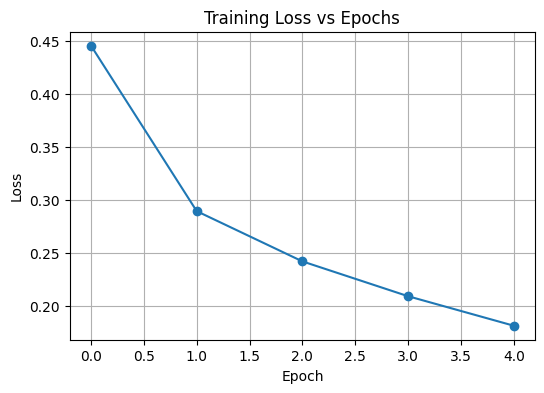

In [24]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, marker='o')
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


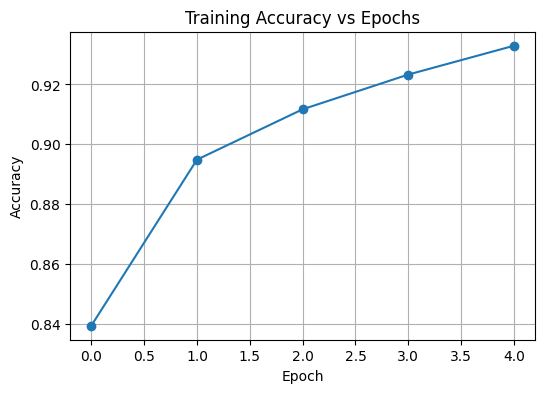

In [25]:
#PLOT TRAINING ACCURACY
plt.figure(figsize=(6,4))
plt.plot(train_accuracies, marker='o')
plt.title("Training Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [26]:
all_preds = []
all_labels = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


/tmp/ipython-input-3492259835.py:14: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image, mode="L")


In [27]:
# CONFUSION MATRIX
cm = confusion_matrix(all_labels, all_preds)
cm

array([[936,   0,  12,   7,   3,   1,  37,   0,   4,   0],
       [  1, 990,   1,   6,   1,   0,   1,   0,   0,   0],
       [ 22,   1, 865,  11,  67,   0,  33,   0,   1,   0],
       [ 24,   8,   1, 937,  18,   1,  10,   0,   1,   0],
       [  3,   0,  23,  19, 927,   0,  28,   0,   0,   0],
       [  0,   0,   0,   0,   0, 982,   0,  11,   1,   6],
       [165,   2,  37,  27,  84,   0, 676,   0,   9,   0],
       [  0,   0,   0,   0,   0,   7,   0, 955,   0,  38],
       [  2,   1,   1,   0,   2,   2,   3,   0, 988,   1],
       [  0,   0,   0,   0,   0,   1,   0,  22,   0, 977]])

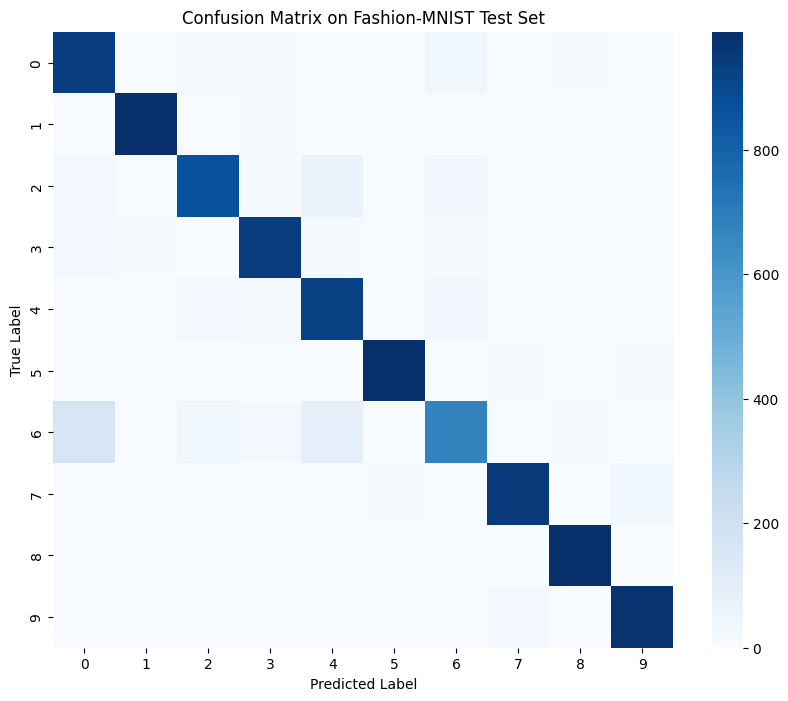

In [28]:
#HEATMAP

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=range(10),
    yticklabels=range(10)
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Fashion-MNIST Test Set")
plt.show()


The confusion matrix shows class-wise performance.
The diagonal elements represent correct predictions, while off-diagonal elements indicate confusion between similar classes like Shirt and T-shirt.

In [29]:
# create model folder
os.makedirs("model", exist_ok=True)

# save trained model
torch.save(model.state_dict(), "model/210102.pth")

print("Model saved successfully!")


Model saved successfully!


In [30]:
!ls model

210102.pth


**facing error to push pth file github from here and then add it by local terminal push**

In [43]:
from google.colab import files
files.download("model/210102.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

In [59]:
model = CNN().to(device)
model.load_state_dict(torch.load("model/210102.pth", map_location=device))
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


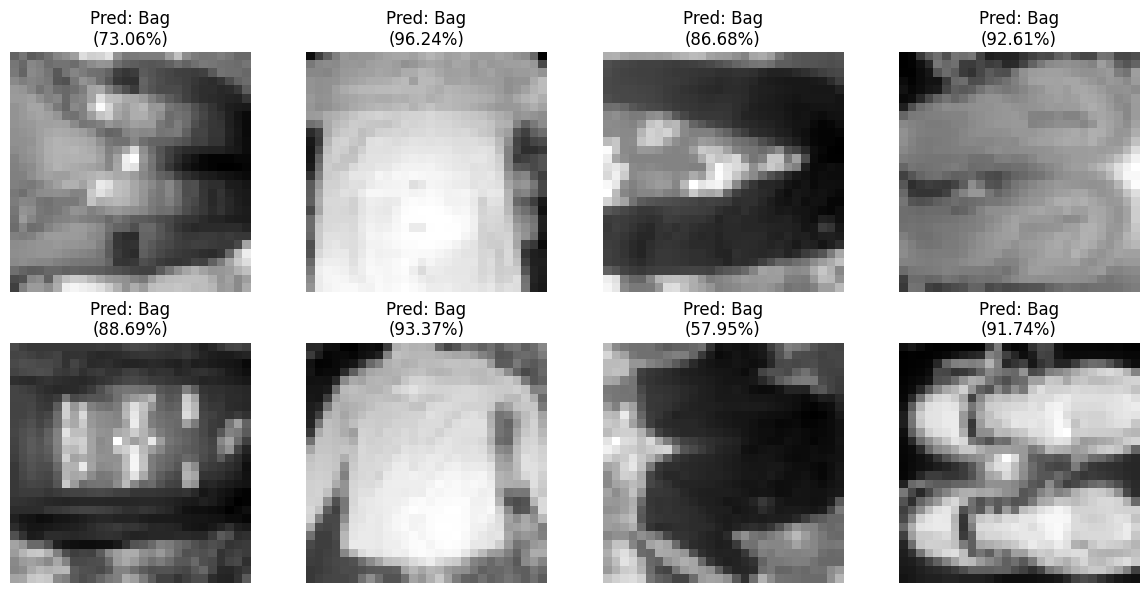

In [60]:
image_files = os.listdir("dataset")

plt.figure(figsize=(12, 6))

for i, img_name in enumerate(image_files):
    img_path = os.path.join("dataset", img_name)

    img = Image.open(img_path).convert("L")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        probs = torch.softmax(output, dim=1)
        confidence, pred = torch.max(probs, 1)

    label = class_names[pred.item()]
    conf = confidence.item() * 100

    plt.subplot(2, 4, i + 1)
    plt.imshow(img.cpu().squeeze(), cmap="gray")
    plt.title(f"Pred: {label}\n({conf:.2f}%)")
    plt.axis("off")

plt.tight_layout()
plt.show()

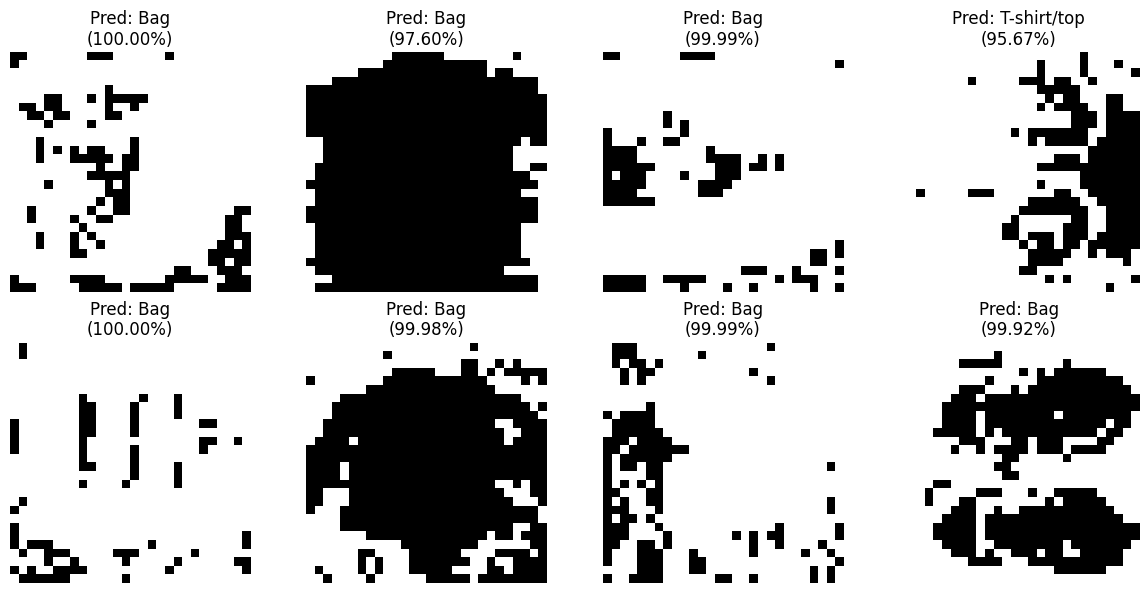

In [61]:
import cv2
import numpy as np

image_files = os.listdir("dataset")

plt.figure(figsize=(12, 6))

for i, img_name in enumerate(image_files):
    img_path = os.path.join("dataset", img_name)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)


    img = cv2.resize(img, (32, 32))


    _, img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)

    img = Image.fromarray(img)

    img = transform(img).unsqueeze(0).to(device)

    # ---- MODEL PREDICTION ----
    with torch.no_grad():
        output = model(img)
        probs = torch.softmax(output, dim=1)
        confidence, pred = torch.max(probs, 1)

    label = class_names[pred.item()]
    conf = confidence.item() * 100

    plt.subplot(2, 4, i + 1)
    plt.imshow(img.cpu().squeeze(), cmap="gray")
    plt.title(f"Pred: {label}\n({conf:.2f}%)")
    plt.axis("off")

plt.tight_layout()
plt.show()

**MY Experience:**

Although preprocessing techniques such as grayscale conversion, center cropping, and background thresholding were applied, the model frequently predicts the “Bag” class for real phone images.
This occurs due to a significant domain shift between Fashion-MNIST’s low-resolution silhouette images and real photographs containing complex lighting, textures, and backgrounds.